<center>
<img src='./img/nsidc_logo.png'/>

# **2.0 Read and Plot SMAP data**

</center>
---

## **1. Overview**

We will read in the SMAP data that was downloaded using the 1.0 Download SMAP data notebook. We will then create a map with SMAP data and plot a time-series at a location on Earth.  


### **Credits**

This tutorial is based on the notebooks originally provided to NSIDC by Adam Purdy. Jennifer Roebuck of NSIDC updated the tutorials to include the latest version of SMAP data and use earthaccess for authentication, seatching for and downloading the data in order to incorporate it into the NSIDC-Data-Tutorials repo. 

For questions regarding the notebook, or to report problems, please create a new issue in the [NSIDC-Data-Tutorials repo](https://github.com/nsidc/NSIDC-Data-Tutorials/issues).

### **Learning Goals**

1. Read in SMAP data and navigate the metadata
2. Create a map with SMAP data
3. Plot a time-series at a location on Earth. 

### **Prerequisites**

1. The nsidc-tutorials environment is set up and activated. This [README](https://github.com/nsidc/NSIDC-Data-Tutorials/blob/main/README.md) has setup instructions.
2. SMAP data that were downloaded in the previous notebook tutorial 1.0 Download SMAP data. 
3. The EASE-Grid 2.0 longitude and latitude data sets. The binary format of these files have been provided within this repo for use in this tutorial, but please note they are also available in NetCDF format from the NSIDC website at this [page](https://nsidc.org/data/NSIDC-0772/versions/1). 


### **Time requirement**

Allow 15 to 20 minutes to complete this tutorial.

## **2. Tutorial steps**

### **Import libraries**


In [1]:
#Import libraries 
import datetime as dt
import glob
import h5py
%matplotlib inline
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import numpy as np
import os
import pandas as pd
import xarray as xr

### **Read SMAP data and navigate metadata**

First we will navigate to the directory with the data we want to use. Then we will generate a list of the files and print out the name of one of the files.

In [ ]:
this_dir = os.getcwd()
L3_SM_P_dir = os.path.join(this_dir, 'data/L3_SM_P/')

flist = glob.glob(os.path.join(L3_SM_P_dir, '*.h5'))
           
filename = flist[0]; 
print("File we are using: " + filename + '\n')

Now we will use `h5py.File()`to open the file. Then we can look at the folders within the HDF5 file to access the data we want. The cell below will print out a list of variables within one of the folders in the HDF5 file, the Soil_Moisture_Retrieval_Data_AM folder.

In [3]:
f = h5py.File(filename, 'r')
print('By using the command h5py.File() a filehandle is returned:')
print(f); print('\n')

print("Now lets look at the groups within the file to access:")
i=0;
for key in f.keys():
    print(str(i)+ '\t'+key)
    i+=1
group_id=list(f.keys())[1];# < Lets focus on the AM overpass for this example
print('\n')
i=0
print("Now lets look at the variables within the filegroup **Soil_Moisture_Retrieval_Data_AM** to access the actual data:")
for var in list(f[group_id].keys()):
    print(str(i)+'\t'+var)
    i+=1

By using the command h5py.File() a filehandle is returned:
<HDF5 file "SMAP_L3_SM_P_20170327_R18290_001.h5" (mode r)>


Now lets look at the groups within the file to access:
0	Metadata
1	Soil_Moisture_Retrieval_Data_AM
2	Soil_Moisture_Retrieval_Data_PM


Now lets look at the variables within the filegroup **Soil_Moisture_Retrieval_Data_AM** to access the actual data:
0	EASE_column_index
1	EASE_row_index
2	albedo
3	albedo_dca
4	albedo_scah
5	albedo_scav
6	boresight_incidence
7	bulk_density
8	clay_fraction
9	freeze_thaw_fraction
10	grid_surface_status
11	landcover_class
12	landcover_class_fraction
13	latitude
14	latitude_centroid
15	longitude
16	longitude_centroid
17	radar_water_body_fraction
18	retrieval_qual_flag
19	retrieval_qual_flag_dca
20	retrieval_qual_flag_scah
21	retrieval_qual_flag_scav
22	roughness_coefficient
23	roughness_coefficient_dca
24	roughness_coefficient_scah
25	roughness_coefficient_scav
26	soil_moisture
27	soil_moisture_dca
28	soil_moisture_error
29	soil_moisture_s

Now that we know the variables within the Soil_Moisture_Retrieval_Data_AM folder lets grab the data we want to plot. First we need to take a look at the extent of the data in terms of the number of rows and columns, we will need this later when opening the EASE-Grid 2.0 lat and lon files.

In [4]:
print('The extent of the data in rows and columns is: '+str(f[group_id][list(f[group_id].keys())[0]].shape))


The extent of the data in rows and columns is: (406, 964)


Based on the list above we can find the index number of the variable we want to plot. For example, soil_moisture is at index 26 in the Soil_Moisture_Retrievel_Data_AM folder. We will use this index value in the cell below to read in the data associated with the soil_moisture variable. 

In [5]:
var_id = list(f[group_id].keys())[26] # soil_moisture
sm_data = f[group_id][var_id][:,:]
sm_ds = f[group_id][var_id]
print('Data are returned as '+str(type(sm_data)) + ' something easy to work with in python.')


Data are returned as <class 'numpy.ndarray'> something easy to work with in python.


This cell plots the out the retrieval quality flag values. For a further explanation of these values, see the third notebook titled '3.0 SMAP Quality Flags'.

In [6]:
ret_flag_L3_P = f[group_id]['retrieval_qual_flag'][:,:]
print(np.unique(ret_flag_L3_P))
print(type(ret_flag_L3_P))

[ 0  1  5  7  8  9 13 15]
<class 'numpy.ndarray'>


### Create a map with SMAP data

Lets quickly plot the soil_moisture variable data to get a sense of what we are working with.

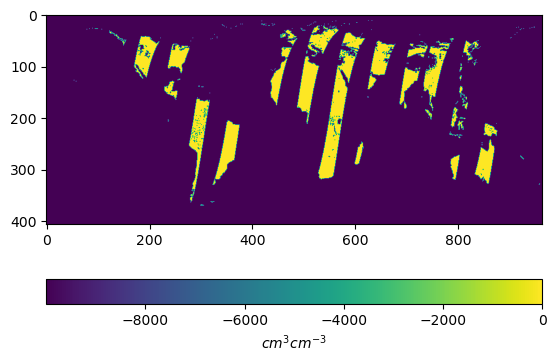

In [7]:
plt.imshow(sm_data)
cbar = plt.colorbar(orientation = 'horizontal')
cbar.set_label('$cm^3 cm^{-3}$')

We need to ignore the null values to get a better idea of the range of values in the data set. 

You can find details on what values are used to represent null in the metadata of the supplemental documents, which are available from the data set landing [page](https://nsidc.org/data/SPL3SMP).

For the soil_moisture variable and most SMAP data sets the null value is -9999. To confirm this is the case we can look at the attributes for the 'soil_moisture' variable. The following cell will find the '_FillValue'_ attribute for the soil_moisture variable and print out its value (in this case it will be -9999).

In [8]:
print(f[group_id][var_id].attrs['_FillValue'])

-9999.0


Now we will replace the FillValue of -9999 with NaN and plot the soil moisture variable again, and set the color bar range to 0 - 0.55. 

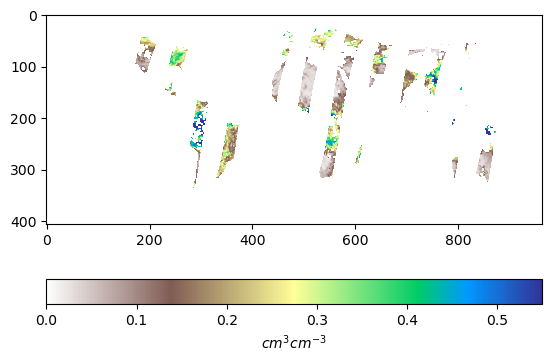

In [9]:
sm_data[sm_data==f[group_id][var_id].attrs['_FillValue']]=np.nan;
plt.imshow(sm_data,vmin=0.,vmax=0.55, cmap = 'terrain_r');
cbar = plt.colorbar(orientation='horizontal')
cbar.set_label('$cm^3 cm^{-3}$')

Lets add some coastlines to this plot, and geolocate the data using the coordinates in the EASE-Grid 2.0 latitude and longitude files. First, we will read in the EASE Grid 2.0 latitude and longitude data sets. 

In [10]:
# Read binary files and reshape to correct size
lats = np.fromfile('EASE2_M36km.lats.964x406x1.double', 
                      dtype=np.float64).reshape((406,964))#< reshape to dimensions above
lons = np.fromfile('EASE2_M36km.lons.964x406x1.double', 
                      dtype=np.float64).reshape((406,964))

Now we will use `cartopy` to plot the soil_moisture variable on a basemap in the Robinson projection. 

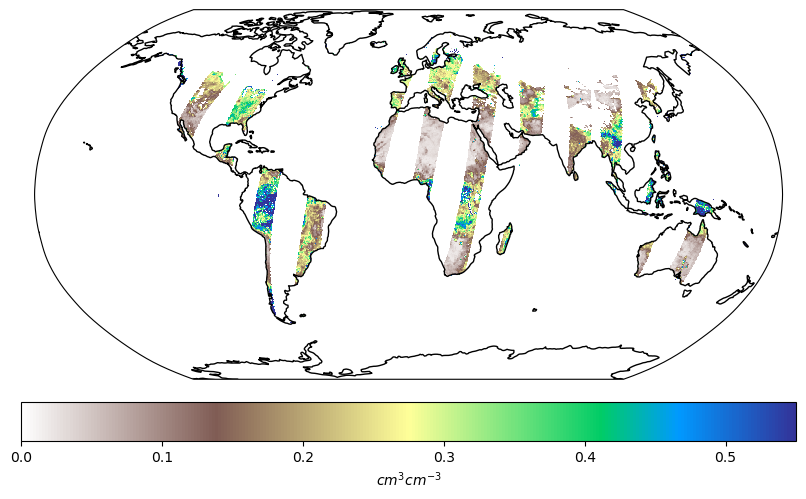

In [11]:
fig = plt.figure(figsize=(10,6))
ax = plt.axes(projection=ccrs.Robinson())
ax.coastlines()
p = plt.pcolormesh(lons, lats, sm_data, transform=ccrs.PlateCarree(), clim=(0.,0.55), cmap='terrain_r')
cbar = fig.colorbar(p, location='bottom', pad=0.05)
cbar.set_label('$cm^3 cm^{-3}$')

Awesome! We have made a global plot, now lets see if we can streamline this to process more data and create a time series. 

### Plot a time-series at a location in Earth

Lets navigate back to the L3_SM_P directory which contains all the files we downloaded and print out a list of all these files 

In [ ]:
for fName in flist:
    print(fName)

Now we will make a function to load these files, and read in the soil_moisture and retrieval_qual_flag variables. 

In [13]:
def read_SML3P(filepath):
    ''' This function extracts lat, lon and soil moisture from SMAP L3 P HDF5 file.
    
    Parameters
    ----------
    filepath : str
        File path of a SMAP L3 HDF5 file
    Returns
    -------
    soil_moisture_am: numpy.array
    '''    
    with h5py.File(filepath, 'r') as f:
        # Extract data info
        group_id_am = 'Soil_Moisture_Retrieval_Data_AM'
        var_id_am = 'soil_moisture'
        flag_id_am = 'retrieval_qual_flag'
        soil_moisture_am = f[group_id_am][var_id_am][:,:]
        flag_am = f[group_id_am][flag_id_am][:,:]
        soil_moisture_am[soil_moisture_am==-9999.0]=np.nan;
        soil_moisture_am[(flag_am>>0)&1==1]=np.nan
        filename = os.path.basename(filepath)
        yyyymmdd= filename.split('_')[4]
        yyyy = int(yyyymmdd[0:4]);        mm = int(yyyymmdd[4:6]);        dd = int(yyyymmdd[6:8])
        date=dt.datetime(yyyy,mm,dd)
    return soil_moisture_am,date

Now we will test that this function works by loading the first file in the list and plotting the soil moisture variable. 

Text(0.5, 1.0, '2017-03-27 00:00:00')

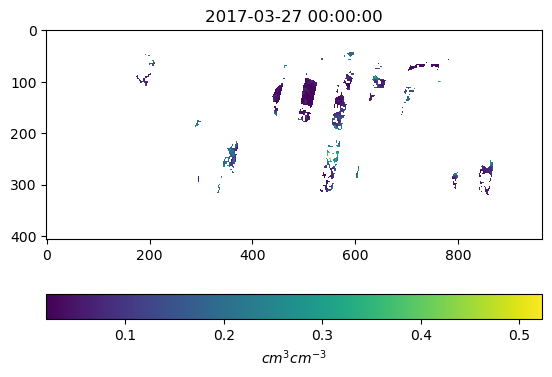

In [14]:
sm_test,date = read_SML3P(flist[0])
plt.imshow(sm_test)
cbar = plt.colorbar(orientation='horizontal')
cbar.set_label('$cm^3 cm^{-3}$')
plt.title(date)

That was just one file, now we will load all 31 files to create a 3D array (soil moisture values over 31 days). The cell below will output the size of this array.

In [15]:
sm_data_3d = np.empty([sm_data.shape[0],sm_data.shape[1],len(flist)])
times = []
print('sm_data_3d has dimensions '+str(sm_data_3d.shape))
i=0
for fName in flist:
    sm_data_3d[:,:,i],time_i = read_SML3P(fName)
    times.append(time_i)
    i+=1


sm_data_3d has dimensions (406, 964, 31)


Next we will calculate the mean soil moisture over 31 days and plot it.

/var/folders/5l/f2dh2cn97r9822g1lk7jnt7r0000gp/T/ipykernel_67424/3387626929.py:1: RuntimeWarning: Mean of empty slice
  sm_mean = np.nanmean(sm_data_3d,2)


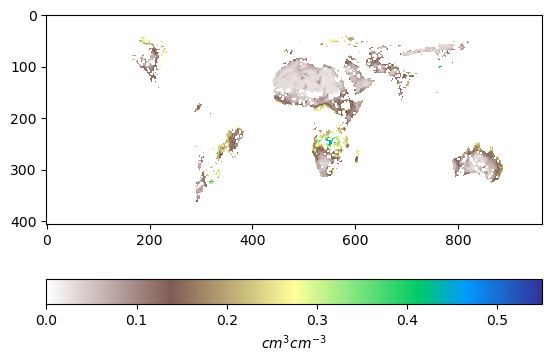

In [16]:
sm_mean = np.nanmean(sm_data_3d,2)
sm_mean.shape
plt.imshow(sm_mean,vmin=0.,vmax=0.55,cmap='terrain_r')
cbar = plt.colorbar(orientation='horizontal')
cbar.set_label('$cm^3 cm^{-3}$')

Lastly, we can select a region within this map and plot the average soil moisture over time for this region.

/var/folders/5l/f2dh2cn97r9822g1lk7jnt7r0000gp/T/ipykernel_67424/3643618336.py:10: RuntimeWarning: Mean of empty slice
  sm_time[i] = np.nanmean(sm_2d[subset]);


Text(0.5, 1.0, 'Soil Moisture')

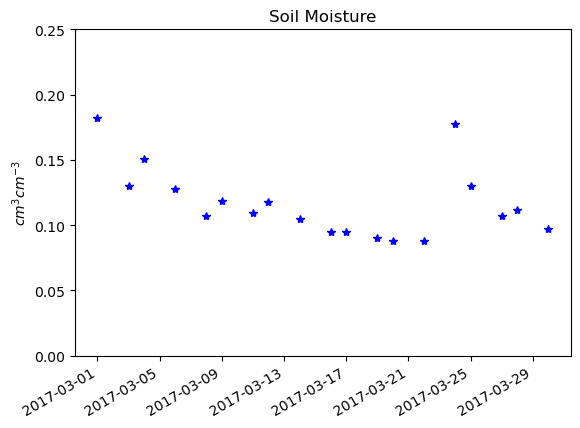

In [17]:
N_lat = 37.5; 
S_lat = 33
W_lon = -113.5
E_lon = -110.0

subset = (lats<N_lat)&(lats>S_lat)&(lons>W_lon)&(lons<E_lon);
sm_time = np.empty([len(flist)]);
for i in np.arange(0,sm_data_3d.shape[2]):
    sm_2d = sm_data_3d[:,:,i]
    sm_time[i] = np.nanmean(sm_2d[subset]); 

# Lets create a pandas series to plot the data
smData = {'sm':sm_time}
sm = pd.DataFrame(smData)
sm['time']=times
sm=sm.set_index('time')

fig, ax1 = plt.subplots()
ax1.plot(sm.index, sm, 'b*')       
ax1.set_ylim([0,0.25])
fig.autofmt_xdate()
ax1.set_ylabel('$cm^3 cm^{-3}$')
plt.title('Soil Moisture')
